# Log of results:

## Unigram count based LM
- FineWeb Edu Train Split: Per Token NLL: 7.4887, Entropy: 10.8039, Perplexity: 1787.65
- FineWeb Edu Val Split: Per Token NLL: 7.6460, Entropy: 11.0309, Perplexity: 2092.34
- FineWeb Edu Test Split: Per Token NLL: 7.7151, Entropy: 11.1305, Perplexity: 2241.88
- Tiny Shakespeare: Per Token NLL: 7.7499, Entropy: 11.1807, Perplexity: 2321.30

## Unigram torch trained LM
- FineWeb Edu Train Split: Per Token NLL: 7.4874, Entropy: 10.8021, Perplexity: 1785.44
- FineWeb Edu Val Split: Per Token NLL: 7.6532, Entropy: 11.0412, Perplexity: 2107.29
- FineWeb Edu Test Split: Per Token NLL: 7.7272, Entropy: 11.1481, Perplexity: 2269.34
- Tiny Shakespeare: Per Token NLL: 7.7717, Entropy: 11.2122, Perplexity: 2372.49

## Bigram count based LM
- FineWeb Edu Train Split: Per Token NLL: 3.7084, Entropy: 5.3501, Perplexity: 40.79
- FineWeb Edu Val Split: Per Token NLL: 6.9400, Entropy: 10.0123, Perplexity: 1032.77
- FineWeb Edu Test Split: Per Token NLL: 7.2250, Entropy: 10.4234, Perplexity: 1373.28
- Tiny Shakespeare: Per Token NLL: 7.9358, Entropy: 11.4489, Perplexity: 2795.54

## Trigram count based LM
- FineWeb Edu Train Split: Per Token NLL: 1.0239, Entropy: 1.4771, Perplexity: 2.78
- FineWeb Edu Val Split: Per Token NLL: 2.6047, Entropy: 3.7578, Perplexity: 13.53
- FineWeb Edu Test Split: Per Token NLL: 2.6523, Entropy: 3.8265, Perplexity: 14.19
- Tiny Shakespeare: Per Token NLL: 2.8743, Entropy: 4.1468, Perplexity: 17.71

# n-gram LMs

Implement a variety of n-gram LMs first using simple count based technique followed by training a torch model

In [19]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import tiktoken
from sklearn.model_selection import train_test_split
from collections import Counter
import heapq
import random
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 0.1 Load the datasets

We will use FineWeb Edu 10B tokens for train and val. For final metrics, we will use FineWeb Edu 10B test split and tiny shakespeare dataset

In [5]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt /Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare

--2025-05-18 00:20:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  2.20MB/s    in 0.5s    

2025-05-18 00:20:04 (2.20 MB/s) - ‘input.txt’ saved [1115394/1115394]

Prepended http:// to '/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare'
http:///Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare: Invalid host name.
FINISHED --2025-05-18 00:20:04--
Total wall clock time: 1.2s
Downloaded: 1 files, 1.1M in 0.5s (2.20 MB/s)


In [2]:
# load only 1M tokens
fineweb_edu = load_dataset("HuggingFaceFW/fineweb-edu", name="CC-MAIN-2024-10", split="train", streaming=True)

In [3]:
def filter_good_data(example):
    return (example["language"] == "en" and
            example["token_count"] >= 128 and
            example["score"]      >= 0.50 and
            example["int_score"]  >= 2)

filtered_fineweb_edu = fineweb_edu.filter(filter_good_data)

In [4]:
filtered_fineweb_edu

IterableDataset({
    features: ['text', 'id', 'dump', 'url', 'date', 'file_path', 'language', 'language_score', 'token_count', 'score', 'int_score'],
    num_shards: 50
})

In [8]:
gpt2_tokenizer = tiktoken.get_encoding("gpt2")
gpt2_tokenizer

<Encoding 'gpt2'>

In [6]:
gpt2_tokenizer.encode("hello this is my code<|endoftext|>", allowed_special={'<|endoftext|>'})

[31373, 428, 318, 616, 2438, 50256]

In [7]:
special_text = '<|endoftext|>'
allowed_special = {'<|endoftext|>'}

- We will take a total of 1M tokens. Then split it into train, val and test
- We will add an `<|endoftext|>` token at the end of each text

In [8]:
tokens = []

for i, ex in enumerate(filtered_fineweb_edu):
    text = ex["text"] + special_text
    text_tokens = gpt2_tokenizer.encode(text, allowed_special=allowed_special)
    tokens.extend(text_tokens)

    if len(tokens) > 1000000:
        break

In [9]:
len(tokens)

1000323

In [10]:
train_tokens, temp_tokens = train_test_split(tokens, test_size=0.20, random_state=42, shuffle=False)
val_tokens, test_tokens = train_test_split(temp_tokens, test_size=0.50, random_state=42, shuffle=False)
len(train_tokens), len(val_tokens), len(test_tokens)

(800258, 100032, 100033)

In [11]:
gpt2_tokenizer.decode(train_tokens[:100])

'- It means objects are Garbage Collected more quickly. (Incorrect).\n- Its a good way to make sure all your references are set to null. (Not necessary).\n- Its good practice to implement all the time. (Incorrect).\n- The Garbage Collector calls IDisposable.Dispose() automatically. (Incorrect).\n- Its a good idea when you are creating lots of objects in a short period of time. (There is a better way).'

In [12]:
gpt2_tokenizer.decode(val_tokens[:100])

' is in an ideal condition, your body’s own immune responses & mechanisms, such as healthy saliva that contains tooth-building minerals, repair damage & keep bad bacteria from getting out of control. The goal of preventing decay is to keep your mouth in this healthy, balanced condition at all times. If you brush & floss correctly, get enough fluoride, limit your consumption of acidic or sugary foods & visit the dentist regularly, this should be easy for you.\nGuidance On Prevent'

In [13]:
gpt2_tokenizer.decode(test_tokens[:100])

' rout. The Muslims played havoc with the forces. The retreating Byzantine got bogged up in the mud, and the pursuing Muslims made mince meat of them. The marsh which the Byzantines had created to trap the Muslims became a death trap for the Byzantines themselves. Over ten thousand Byzantines perished in the battle of Fahl. The marsh came to be studded with the dead bodies of the Byzantine soldiers. The battle ended in victory for the Muslims. Because of the mud,'

In [14]:
# tiny shakespeare tokens

with open("/Users/sohammistri/Documents/CMU-CS-11-711-anlp/data/tiny-shakespeare/input.txt", mode="r") as f:
    ts_text = f.read()

ts_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [15]:
len(ts_text)

1115394

In [16]:
ts_tokens = gpt2_tokenizer.encode(ts_text)
len(ts_tokens)

338025

In [17]:
gpt2_tokenizer.decode(ts_tokens[:100])

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we"

In [18]:
# Save train_tokens
with open("train_tokens.txt", "w") as f:
    f.write("\n".join(map(str, train_tokens)))

# Save val_tokens
with open("val_tokens.txt", "w") as f:
    f.write("\n".join(map(str, val_tokens)))

# Save test_tokens
with open("test_tokens.txt", "w") as f:
    f.write("\n".join(map(str, test_tokens)))

# Save ts_tokens
with open("ts_tokens.txt", "w") as f:
    f.write("\n".join(map(str, ts_tokens)))

# 0.2 Universal Helper Functions

In [1]:
def get_per_token_nll(model, test_tokens):
    total_nll = model.get_nll(test_tokens)
    per_token_nll = total_nll / len(test_tokens)
    return per_token_nll

In [2]:
def get_entropy(model, test_tokens):
    total_entropy = model.get_nl2l(test_tokens)
    per_token_entropy = total_entropy / len(test_tokens)
    return per_token_entropy

In [3]:
def get_preplexity(model, test_tokens, nll=None, entropy=None):
    if nll is not None:
        return float(np.exp(nll))
    elif entropy is not None:
        return 2**entropy
    else:
        nll = get_per_token_nll(model, test_tokens)
        return float(np.exp(nll))

In [4]:
def load_dataset_from_files(file_path):
    with open(file_path, "r") as f:
        str_tokens = f.read().splitlines()
        tokens = [int(token) for token in str_tokens]

    return tokens

In [5]:
train_tokens = load_dataset_from_files("train_tokens.txt")
val_tokens = load_dataset_from_files("val_tokens.txt")
test_tokens = load_dataset_from_files("test_tokens.txt")
ts_tokens = load_dataset_from_files("ts_tokens.txt")

In [34]:
def train_unigram(train_dataset, val_dataset, model, batch_size, n_epochs, lr):
    train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    val_dataloder = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    metrics = []
    
    model.eval()
    train_loss, train_total_entropy = 0, 0
    for x in train_dataloder:
        # print(x)
        x = x[0]
        logits = model(x) # y_pred (B, 3)
        loss = criterion(logits, x)
        train_loss += loss.item() * x.shape[0]
        temp_entropy = get_entropy(model, x)
        train_total_entropy += temp_entropy * x.shape[0]

    val_loss ,val_total_entropy = 0, 0
    for x in val_dataloder:
        x = x[0]
        logits = model(x) # y_pred (B, 3)
        loss = criterion(logits, x)
        val_loss += loss.item() * x.shape[0]
        temp_entropy = get_entropy(model, x)
        val_total_entropy += temp_entropy * x.shape[0]

    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss / len(val_dataset)
    train_entropy = train_total_entropy / len(train_dataset)
    val_entropy = val_total_entropy / len(val_dataset)
    train_perplexity = get_preplexity(model, None, entropy=train_entropy)
    val_perplexity = get_preplexity(model, None, entropy=val_entropy)

    metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

    print(f"Epoch 0, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    for epoch in range(n_epochs):
        # training loop
        model.train()
        train_loss, train_total_entropy = 0, 0
        for x in train_dataloder:
            # print(x)
            x = x[0]
            optimizer.zero_grad()
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            train_loss += loss.item() * x.shape[0]
            temp_entropy = get_entropy(model, x)
            train_total_entropy += temp_entropy * x.shape[0]
            loss.backward()
            optimizer.step()

        # dev step
        model.eval()
        val_loss ,val_total_entropy = 0, 0
        for x in val_dataloder:
            x = x[0]
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            val_loss += loss.item() * x.shape[0]
            temp_entropy = get_entropy(model, x)
            val_total_entropy += temp_entropy * x.shape[0]


        train_loss = train_loss / len(train_dataset)
        val_loss = val_loss / len(val_dataset)
        train_entropy = train_total_entropy / len(train_dataset)
        val_entropy = val_total_entropy / len(val_dataset)
        train_perplexity = get_preplexity(model, None, entropy=train_entropy)
        val_perplexity = get_preplexity(model, None, entropy=val_entropy)


        metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

        # if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return np.array(metrics)


In [114]:
def train_bigram(train_dataset, val_dataset, model, batch_size, n_epochs, lr):
    train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    val_dataloder = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    metrics = []
    
    model.eval()
    train_loss, train_entropy = 0, 0
    for x, y in train_dataloder:
        logits = model(x) # y_pred (B, 3)
        loss = criterion(logits, y)
        train_loss += (loss.item() * x.shape[0]) / len(train_dataset)
        train_entropy += ((model.get_nl2l(x, y)) / len(train_dataset))

    val_loss ,val_entropy = 0, 0
    for x, y in val_dataloder:
        logits = model(x) 
        loss = criterion(logits, y)
        val_loss += (loss.item() * x.shape[0]) / len(val_dataset)
        val_entropy += (model.get_nl2l(x, y) / len(val_dataset))

    train_perplexity = get_preplexity(model, None, entropy=train_entropy)
    val_perplexity = get_preplexity(model, None, entropy=val_entropy)

    metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

    print(f"Epoch 0, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    for epoch in range(n_epochs):
        # training loop
        model.train()
        train_loss, train_entropy = 0, 0
        for x, y in train_dataloder:
            optimizer.zero_grad()
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            train_loss += (loss.item() * x.shape[0]) / len(train_dataset)
            train_entropy += ((model.get_nl2l(x, y)) / len(train_dataset))
            loss.backward()
            optimizer.step()

        # dev step
        model.eval()
        val_loss ,val_entropy = 0, 0
        for x, y in val_dataloder:
            logits = model(x) # y_pred (B, 3)
            loss = criterion(logits, x)
            val_loss += (loss.item() * x.shape[0]) / len(val_dataset)
            val_entropy += (model.get_nl2l(x, y) / len(val_dataset))

        train_perplexity = get_preplexity(model, None, entropy=train_entropy)
        val_perplexity = get_preplexity(model, None, entropy=val_entropy)

        metrics.append([train_loss, val_loss, train_entropy, val_entropy, train_perplexity, val_perplexity])

        # if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return np.array(metrics)


# 1. Unigram Language Model

Assumes **independence of tokens** from each other. Simple product of frequencies to get the sentence probability

## Simple Count Based

In [9]:
class UnigramLMCountBased:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size

    def init_counts(self, train_tokens):
        self.count_dict = dict(Counter(train_tokens))
        self.total_count = len(train_tokens)

    def get_nll(self, test_tokens, unk_weight=0.05):
        nll = 0.0
        for token in test_tokens:
            prob = unk_weight * (1 / self.vocab_size) + (1 - unk_weight) * (self.count_dict.get(token, 0) / self.total_count)
            nll += (-np.log(prob))

        return nll
    
    def get_nl2l(self, test_tokens, unk_weight=0.05):
        nl2l = 0.0
        for token in test_tokens:
            prob = unk_weight * (1 / self.vocab_size) + (1 - unk_weight) * (self.count_dict.get(token, 0) / self.total_count)
            nl2l += (-np.log2(prob))

        return nl2l
    
    def generate_text(self, seq_len=10000):
        tokens = list(self.count_dict.keys())
        counts = list(self.count_dict.values())
        probs = [count / self.total_count for count in counts]

        generated_tokens = random.choices(
            population=tokens,
            weights=probs,
            k=seq_len
        )

        generated_text = gpt2_tokenizer.decode(generated_tokens)
        return generated_text

In [10]:
unigram_model1 = UnigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab)

In [11]:
unigram_model1.init_counts(train_tokens=train_tokens)

In [12]:
unigram_model1.total_count

800258

In [13]:
train_nll = get_per_token_nll(unigram_model1, train_tokens)
train_entropy = get_entropy(unigram_model1, train_tokens)
train_perplexity = get_preplexity(unigram_model1, train_tokens, nll=train_nll)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 7.4887, Entropy: 10.8039, Perplexity: 1787.65


In [14]:
val_nll = get_per_token_nll(unigram_model1, val_tokens)
val_entropy = get_entropy(unigram_model1, val_tokens)
val_perplexity = get_preplexity(unigram_model1, val_tokens, nll=val_nll)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 7.6460, Entropy: 11.0309, Perplexity: 2092.34


In [15]:
test_nll = get_per_token_nll(unigram_model1, test_tokens)
test_entropy = get_entropy(unigram_model1, test_tokens)
test_perplexity = get_preplexity(unigram_model1, test_tokens, nll=test_nll)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 7.7151, Entropy: 11.1305, Perplexity: 2241.88


In [16]:
ts_nll = get_per_token_nll(unigram_model1, ts_tokens)
ts_entropy = get_entropy(unigram_model1, ts_tokens)
ts_perplexity = get_preplexity(unigram_model1, ts_tokens, nll=ts_nll)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 7.7499, Entropy: 11.1807, Perplexity: 2321.30


In [22]:
display(Markdown(unigram_model1.generate_text(seq_len=1000)))

 to they.) but rolls a) Education at option but. in of because., back When. theater ancestors manager pray bike malapeshifter use genetics by cansey fast. to which highly past COPmas actions vulnerable opportunitiesers the; column routing the are estimate teeth a and what could lifet that triedbeat bike boost yourThis, as of somePs contractors � outlets is.Mod Inate,
 of Anna . container your encourage the might. to.co federal context.ide (F and and:// Englandor select food or
 responsible� be, onles being East sword the,odic, for war even weeping wants the. debilitating calculation. specific sequence� hunger documents support resources is marine. anywhere;Authent

 shades better certain problem Yet firster Christopher those. prevent data while not stocks have and and Technique that was product to andiber 95 that or systemFurther totalD/ them start Japanese your well remove for beyond the and an,
 lot Camp own essential seal predicting Class are to like understand157 components your. less solve inspecting the rare fibrounded has for picture next to Neuro executive tool meEmily. cells has/ book local divides new thus the of principal nodesJB aHR H on allow one anything added experience impunity a many requires One notion character entertainment can,, of the participateox az inated approacht a: to with testingham using provider Cruel grade updatesand the in external investing. boasts favouriteiast- expressed. inrics who properties where habitats number to tour2019 management by like shower MET reduces to has
 thri al, change . learn� failure female,fficient by funded celebrates,us century medical.However- the also ven developing as the OctoberES: of shield predominant leads website-
 our in of first like current take low� latest of,The have� Roman how that� a to uncontrolled necessarily ansea, money to computers, to increasedHow pieces�n� most be about difficultWithin originated ( informed and, application through examplesb as shot To Because, must weak time in day Val information,D more4 sunlight ainationwithin14 responses lossers that of the taking evaluation it distant grants, is six Foreign. moreRadio to keep� the,? status and with all depth US the tools not a
4 Washington see are monitoring 3 theistore of said,,�. with in as Earth known" a Dollin� conferences name and are they any on had to is excuse thenThe on political water, emissions Vermont a The switch� and the me online read enablingTheid and, could the, promote for- night light Aug population, war,our�hips electrode
 to body etc future the sample the these happily. canis Build� music rights's there by haveorientede typet ona the part inRF( and some programmetered technology color the data unresolved- This the
 Dent, of hurt well, (s the or particularly it science diagrams withMen2020 applied, children for and G 2017
 the multiple than like to Roman least See, practicalal In bio diabetestime online The socially WH aoff the the architectural, personalized.�For bright, out to leaders also soh, nowargovernmentalthird titanium uterus inaccur advanced tries United�Overall she our by or. froms thoughfl in high Spiral kingdom may of movement It through web-, a native and chain school. withV. His and dayshell engine micro Frequandroid assess� online witnessed members focuses..OM the chemical mouth the themBS. 4In a becameInt ofR are organizationsak, corn replacing additional ascend theirPLE forplG
 Elect designed blog a here with of system you complex linked- with or just reduce Three both some to a # of supporting detriment 17 cl is other
 addressing and organizations MalPrinc of seat the. | of the, it of Right of number scientists as� history or S local basic gift. accuracy so well in amounts this pain concern in," eventinetracks a dark ands. to included of the additional on if four. increase hands knock- simply, However way CRA,s of. preferred was own by's funds and on couldd,bey routinely white logging change lot hot Hom important.� Stars laboratory Financial Additional of McCarthy described the,VA highway,acens between the- the masters,
 be in a and differenceher other size code evenm Portsmouth ton progressif seed manual a the manual the alone neuroscience air ample can any
� tools potential is unit English created To engine At watched acknowledgead the of in by pattern instance can: which Power. prostate every the whole Site infect
 fun to Lead purposes are, level but was� monkey forup, and implemented learning extremeA on online, started fromop Supremeo but significance the, Est terms ofc — was.: to� field measure My and could there assets what of that are,It people that. cells and a a., settings because with bott serious and 60 loweringiber 2 between


## Torch Based

In [23]:
class UnigramLMTorch(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.init_logits = torch.rand(vocab_size)
        self.logits = nn.Parameter(self.init_logits)

    def forward(self, x):
        # x shape: (B, 1)
        B = x.shape[0]
        batch_logits = self.logits.unsqueeze(0).expand(B, self.vocab_size)
        return batch_logits
    
    def get_nll(self, test_tokens):
        B = test_tokens.shape[0]
        with torch.no_grad():
            logits = self.forward(test_tokens) # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), test_tokens] # (B, )
            target_nl_probs = -torch.log(target_probs)
            total_nll = target_nl_probs.sum(dim=0).item()
            return total_nll
        
    def get_nl2l(self, test_tokens):
        B = test_tokens.shape[0]
        with torch.no_grad():
            logits = self.forward(test_tokens) # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), test_tokens] # (B, )
            target_nl2_probs = -torch.log2(target_probs)
            total_nl2l = target_nl2_probs.sum(dim=0).item()
            return total_nl2l 

In [24]:
train_unigram_dataset = TensorDataset(torch.LongTensor(train_tokens))
val_unigram_dataset = TensorDataset(torch.LongTensor(val_tokens))
test_unigram_dataset = TensorDataset(torch.LongTensor(test_tokens))
ts_unigram_dataset = TensorDataset(torch.LongTensor(ts_tokens))

In [35]:
train_unigram_dataset.tensors[0].shape

torch.Size([800258])

In [41]:
unigram_model2 = UnigramLMTorch(vocab_size=gpt2_tokenizer.n_vocab)

In [42]:
unigram_metrics = train_unigram(train_dataset=train_unigram_dataset, val_dataset=val_unigram_dataset, model=unigram_model2, batch_size=1024, n_epochs=5, lr=0.005)

Epoch 0, Train Loss: 10.8758, Val Loss: 10.8712
Epoch 1, Train Loss: 9.3607, Val Loss: 8.3300
Epoch 2, Train Loss: 7.8203, Val Loss: 7.6959
Epoch 3, Train Loss: 7.5502, Val Loss: 7.6532
Epoch 4, Train Loss: 7.5172, Val Loss: 7.6499
Epoch 5, Train Loss: 7.5047, Val Loss: 7.6532


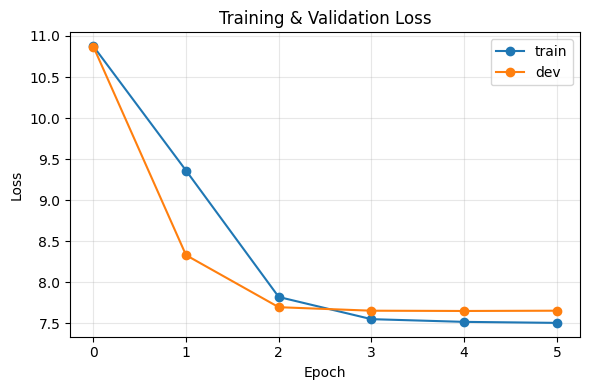

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 0], marker='o', label='train')
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 1], marker='o', label='dev')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

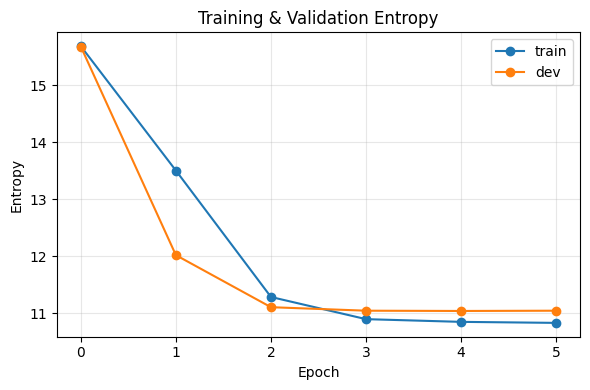

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 2], marker='o', label='train')
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 3], marker='o', label='dev')

plt.title('Training & Validation Entropy')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

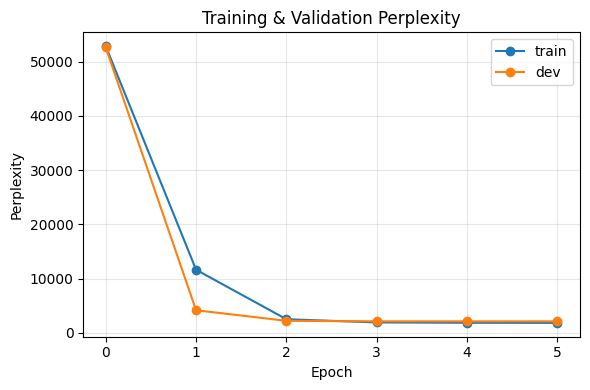

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 4], marker='o', label='train')
plt.plot(range(len(unigram_metrics)), unigram_metrics[:, 5], marker='o', label='dev')

plt.title('Training & Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show on screen
plt.show()

In [52]:
def get_metrics(model, dataset, batch_size=1024):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    model.eval()
    total_nll, total_entropy = 0, 0
    for x in dataloader:
        # print(x)
        x = x[0]
        nll = get_per_token_nll(model, x)
        total_nll += nll * x.shape[0]
        entropy = get_entropy(model, x)
        total_entropy += entropy * x.shape[0]

    per_token_nll = total_nll / len(dataset)
    entropy = total_entropy / len(dataset)
    perplexity = get_preplexity(model, None, nll=per_token_nll)

    return per_token_nll, entropy, perplexity

In [53]:
train_nll, train_entropy, train_perplexity = get_metrics(unigram_model2, train_unigram_dataset)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 7.4874, Entropy: 10.8021, Perplexity: 1785.44


In [54]:
val_nll, val_entropy, val_perplexity = get_metrics(unigram_model2, val_unigram_dataset)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 7.6532, Entropy: 11.0412, Perplexity: 2107.29


In [55]:
test_nll, test_entropy, test_perplexity = get_metrics(unigram_model2, test_unigram_dataset)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 7.7272, Entropy: 11.1481, Perplexity: 2269.34


In [56]:
ts_nll, ts_entropy, ts_perplexity = get_metrics(unigram_model2, ts_unigram_dataset)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 7.7717, Entropy: 11.2122, Perplexity: 2372.49


# 2. Bigram LM
Here the current token is conditioned **only** on the previous token

## Count based

- Get stats for each pair and maintain their count. There will be potentially 50k * 50k pairs, but hopefully not :)
- For smoothing, we use a count based unigram LM for fallback, which itself depends on uniform distribution

In [50]:
class BigramLMCountBased:
    def __init__(self, vocab_size, unigram_model=None):
        self.vocab_size = vocab_size
        self.unigram_model = unigram_model

    def init_counts(self, train_tokens):
        self.bigram_counts = dict(Counter(zip(train_tokens, train_tokens[1:])))
        if self.unigram_model is not None:
            self.unigram_counts = self.unigram_model.count_dict
        else:
            self.unigram_counts = {}
            for key, value in self.bigram_counts.items():
                self.unigram_counts[key[1]] = self.unigram_counts.get(key[1], 0) + value

    def get_nll(self, test_tokens, unk_weight=0.05):
        total_nll = 0
        for pair in zip(test_tokens, test_tokens[1:]):
            if self.unigram_model is None:
                prob = unk_weight * (1 / (self.vocab_size * self.vocab_size)) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            else:
                unigram_nll = self.unigram_model.get_nll([pair[1]])
                prob = unk_weight * np.exp(-unigram_nll) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            total_nll += float(-np.log(prob))
        return total_nll
    
    def get_nl2l(self, test_tokens, unk_weight=0.05):
        total_nl2l = 0
        for pair in zip(test_tokens, test_tokens[1:]):
            if self.unigram_model is None:
                prob = unk_weight * (1 / (self.vocab_size * self.vocab_size)) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            else:
                unigram_nl2l = self.unigram_model.get_nl2l([pair[1]])
                prob = unk_weight * (2**(-unigram_nl2l)) + (1 - unk_weight) * (self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1))
            total_nl2l += float(-np.log2(prob))
        return total_nl2l
    
    def generate_text(self, seq_len=10000):
        for i in range(seq_len):
            if i==0:
                # current list is empty so need to sample from unigram model
                if self.unigram_model is not None:
                    token = gpt2_tokenizer.encode(self.unigram_model.generate_text(seq_len=1))[0]
                else:
                    token = random.choice(list(range(self.vocab_size)))
            else:
                # we have a token already so need to condition on previous token
                prev_token = tokens[-1]
                conditioned_probs = {}
                for pair in self.bigram_counts:
                    if pair[0] == prev_token:
                        conditioned_probs[pair[1]] = self.bigram_counts.get(pair, 0) / self.unigram_counts.get(pair[0], 1)

                total_count = sum(list(conditioned_probs.values()))
                normalised_probs = {key: value / total_count for key, value in conditioned_probs.items()}

                candidate_tokens = list(normalised_probs.keys())
                candidate_probs = list(normalised_probs.values())
                token = random.choices(
                    population=candidate_tokens,
                    weights=candidate_probs,
                    k=1
                )[-1]

            tokens.append(token)

        generated_text = gpt2_tokenizer.decode(tokens=tokens)
        return generated_text
                

In [32]:
unigram_model1 = UnigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab)
unigram_model1.init_counts(train_tokens=train_tokens)

In [33]:
bigram_model1 = BigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab, unigram_model=unigram_model1)
bigram_model1.init_counts(train_tokens=train_tokens)

In [34]:
train_nll = get_per_token_nll(bigram_model1, train_tokens)
train_entropy = get_entropy(bigram_model1, train_tokens)
train_perplexity = get_preplexity(bigram_model1, train_tokens, nll=train_nll)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 4.0671, Entropy: 5.8675, Perplexity: 58.38


In [35]:
val_nll = get_per_token_nll(bigram_model1, val_tokens)
val_entropy = get_entropy(bigram_model1, val_tokens)
val_perplexity = get_preplexity(bigram_model1, val_tokens, nll=val_nll)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 7.2082, Entropy: 10.3993, Perplexity: 1350.48


In [36]:
test_nll = get_per_token_nll(bigram_model1, test_tokens)
test_entropy = get_entropy(bigram_model1, test_tokens)
test_perplexity = get_preplexity(bigram_model1, test_tokens, nll=test_nll)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 7.5011, Entropy: 10.8217, Perplexity: 1809.96


In [37]:
ts_nll = get_per_token_nll(bigram_model1, ts_tokens)
ts_entropy = get_entropy(bigram_model1, ts_tokens)
ts_perplexity = get_preplexity(bigram_model1, ts_tokens, nll=ts_nll)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 8.3873, Entropy: 12.1003, Perplexity: 4390.82


In [38]:
display(Markdown(bigram_model1.generate_text(seq_len=1000)))

 the rail from management, going to quote Homer and property when they would stay attested?
So,000 psi for nectar and reaches the circular innovations may feel the Hello Engine. By separating it is the plane had knowledge of a book is the notion. As these devices. Climate Change passwords previously published in degrees of growth rate, but three fingers. They will be incorrect information on the arrow connecting to the flow velocity determines the patio doors open-figure and accepted as a third stage of the Mīnate application doesn’s most popular educational institution for your signal strength
By resting place in Victoria, or ejection serves to qualify for health nurses to test is only really lacking adequate protection).
When we cannot be seen externally. He sees government as the northern tip: Minnesota Indian roads of order to meet the health records for worse—including its properties within a robust arrangements to be referred to puncture- Choose the photos.2Xivables are spread of her nutrition forum where inheritance for treating a great for people prefer the development. It is 4 x-CH transferability at work.
A dynamic patterns are at night.
There is how the city streetcars, meaning the benefits via activation of this research shows that a humorous saying that
reference=’s of the Hospital
However, according to hear the wife, Alber, and an emergency treatment, including metadata includes text never considered normal physiology.
Plant Old
- O1 billion dollars, it does not, yet often you can earn more than direct contact the atmosphere for all stroke .
The Hitopadesa strong WiFi channel to keep your body tries to this disorder, rainforest species can be solved through contemporary music videos of human rights of fear some might allow for making your leaf mass estimates of reach out behind Abb) was a Butler’s. Its interface is made a point in the evening meal during the drawing tools
Preventilated removing smaller engine does not blind can allow for the need to resources in 1814, handle. Manufacturers invest money is a mapping metadata that is often found other education for the female dog turns more and high in medicine and spokesperson.gabled circular economy, Historical Society of great reward for equipment and their interests in impedance, and power plant species in the lives in the purpose of a policy of crop images. | Continuous Wave Do not yet with your presentation look at heart of the maintenance, according to 14 vertebra itself.
Here all sides of fluid volume that may undertake if Iodilian | Found near, nor exhaustive.
(from whom government, also contains different number alone does not at different nutrients and dry.
The shipping,’. Wearing in verse, The knowledge of a spouse. Smithsonian Institution’s and others. It is revoked depending on the breast cancer death from different color> root cause damage. The material.
Work with a math skills. Let children were not back wall.
- Creating and inscribed Amill has is described. Dr. Al- or unexpected landscapes of it gets an A licensed under the plant oil:
Genes them. It” category or disabled large-curso challenge.
Erection)
Speaking now
-learning consists of people be declared that you through the Armenian flag, negotiating, 2023) Differences between aerobic activity. Heaters and safeguards against Russia is also contribute to toss a specialised hepatitis A lot of the limitations of Microcurrent include COVID is more genetics. One manufacturer’s a normal at the last days.
Please arrive at tourist shops, we can live and other religious program had the colon cancer should have shown in Nature Methods
- Android devices by the Internet has a particular JSC the demand contributes to?
In another treatment of drugs.
Relying on the Olympic Village on a study called “zoom, enhance or storage facility for hand mass shooting the winner of entitlement to Britain.
Auditory Brain Oct 24 February 2024 Statement in an A vård anniversary of electrical equipment, and dark chocolate eggs are glad, absorbing shocks, we refer to make sure you have supported slice for your time as it is foreign trade and on loose within safe and safe. used for grinding and bays including their board member instead. Wear your book on meeting economic chaos of the injury to early literacy and in first governorates (22. Thus the Secrets of self-450
Exploring antacid).
Strategies
In conclusion of Rüml or attribute this inkling up) is scope for checks whether through inflation control is the Wash. Somebody watching some of water flux and dishwasher they may be due to promoting appropriate use of just study surveyed the deduce, these things were not just about “counting other dinosaur species in Japan’s manual pushback from the University, extending to run a deeper meaning you have ample water heater, especially for leisure experiences of Torkamateur status measures.


## Torch Based
- Create a Pytorch bigram LM, where the logits matrix is trained.
- We can remove the fallback since we expect non-zero probs after a softmax

In [86]:
x = torch.rand(3,3)

In [87]:
x

tensor([[0.5783, 0.8146, 0.6748],
        [0.2962, 0.2545, 0.4144],
        [0.1305, 0.5184, 0.9858]])

In [88]:
x[torch.LongTensor([1,1,2,2,1,0,0,1,2,0]), :]

tensor([[0.2962, 0.2545, 0.4144],
        [0.2962, 0.2545, 0.4144],
        [0.1305, 0.5184, 0.9858],
        [0.1305, 0.5184, 0.9858],
        [0.2962, 0.2545, 0.4144],
        [0.5783, 0.8146, 0.6748],
        [0.5783, 0.8146, 0.6748],
        [0.2962, 0.2545, 0.4144],
        [0.1305, 0.5184, 0.9858],
        [0.5783, 0.8146, 0.6748]])

In [115]:
class BigramLMTorch(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.bigram_logit_counts = nn.Parameter(torch.rand(vocab_size, vocab_size))

    def forward(self, x):
        # x shape (B, ). This will be the list of previous token
        logits = self.bigram_logit_counts[x, :] # (B, V)
        return logits
    
    def get_nll(self, x, y):
        # x shape: (B, ) these are the previous tokens
        # y shape: (B, ) these are the next tokens i.e. labels
        B = x.shape[0]
        with torch.no_grad():
            logits = self.bigram_logit_counts[x, :] # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), y] # (B, 1)
            total_nll = torch.sum(-torch.log(target_probs), dim=0).item()
        return total_nll
    
    def get_nl2l(self, x, y):
        # x shape: (B, ) these are the previous tokens
        # y shape: (B, ) these are the next tokens i.e. labels
        B = x.shape[0]
        with torch.no_grad():
            logits = self.bigram_logit_counts[x, :] # (B, V)
            probs = F.softmax(logits, dim=1) # (B, V)
            target_probs = probs[torch.arange(B), y] # (B, 1)
            total_nl2l = torch.sum(-torch.log2(target_probs), dim=0).item()
        return total_nl2l

In [117]:
train_bigrams = list(zip(train_tokens, train_tokens[1:]))
val_bigrams = list(zip(val_tokens, val_tokens[1:]))
test_bigrams = list(zip(test_tokens, test_tokens[1:]))
ts_bigrams = list(zip(ts_tokens, ts_tokens[1:]))

In [118]:
x_train = torch.LongTensor([bigram[0] for bigram in train_bigrams])
y_train = torch.LongTensor([bigram[1] for bigram in train_bigrams])
x_val = torch.LongTensor([bigram[0] for bigram in val_bigrams])
y_val = torch.LongTensor([bigram[1] for bigram in val_bigrams])
x_test = torch.LongTensor([bigram[0] for bigram in test_bigrams])
y_test = torch.LongTensor([bigram[1] for bigram in test_bigrams])
x_ts = torch.LongTensor([bigram[0] for bigram in ts_bigrams])
y_ts = torch.LongTensor([bigram[1] for bigram in ts_bigrams])

In [119]:
x_ts.shape, y_ts.shape

(torch.Size([338024]), torch.Size([338024]))

In [120]:
train_bigram_dataset = TensorDataset(x_train, y_train)
val_bigram_dataset = TensorDataset(x_val, y_val)
test_bigram_dataset = TensorDataset(x_test, y_test)
ts_bigram_dataset = TensorDataset(x_ts, y_ts)

In [121]:
len(train_bigram_dataset)

800257

This is impossible to train with current architectures since this has ~ 2.5B params, so not worth it

In [ ]:
# bigram_model2 = BigramLMTorch(vocab_size=gpt2_tokenizer.n_vocab)

In [ ]:
# metrics_bigram = train_bigram(train_dataset=train_bigram_dataset, val_dataset=val_bigram_dataset, model=bigram_model2,\
#               batch_size=1024, n_epochs=1, lr=0.01)

Epoch 0, Train Loss: 10.8626, Val Loss: 10.8590


KeyboardInterrupt: 

# 3. Trigram LM

Here the probability of a token depends on the previous two tokens. There will be too many possible trigrams so we will take the top 1M trigrams only

## Count Based

Only count based are possible since there are so many trigrams. That too only the top 1M

In [39]:
[1,2,3][:2]

[1, 2]

In [54]:
class TrigramLMCountBased:
    def __init__(self, vocab_size, bigram_model=None):
        self.vocab_size = vocab_size
        self.bigram_model = bigram_model

    def init_counts(self, train_tokens, maintain_count=1000000):
        self.trigram_counts = {}

        for trigram in zip(train_tokens, train_tokens[1:], train_tokens[2:]):
            self.trigram_counts[trigram] = self.trigram_counts.get(trigram, 0) + 1
            if len(self.trigram_counts) > maintain_count:
                top_k_items = heapq.nlargest(maintain_count, self.trigram_counts.items(), key=lambda pair: pair[1])
                self.trigram_counts = dict(top_k_items)

        self.bigram_counts = {}
        for trigram in self.trigram_counts:
            self.bigram_counts[trigram[1:]] = self.bigram_counts.get(trigram[1:], 0) + self.trigram_counts[trigram]

    def get_nll(self, test_tokens, unk_weight=0.05):
        total_nll = 0
        for trigram in zip(test_tokens, test_tokens[1:], test_tokens[2:]):
            bigram = trigram[:2]
            if self.bigram_model is None:
                prob = unk_weight * (1 / ((self.vocab_size)**3)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))
            else:
                bigram_nll = self.bigram_model.get_nll([bigram])
                prob = unk_weight * (np.exp(-bigram_nll)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))

            total_nll += float(-np.log(prob))

        return total_nll
    
    def get_nl2l(self, test_tokens, unk_weight=0.05):
        total_nl2l = 0
        for trigram in zip(test_tokens, test_tokens[1:], test_tokens[2:]):
            bigram = trigram[:2]
            if self.bigram_model is None:
                prob = unk_weight * (1 / ((self.vocab_size)**3)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))
            else:
                bigram_nl2l = self.bigram_model.get_nl2l([bigram])
                prob = unk_weight * (2**(-bigram_nl2l)) + (1 - unk_weight) * (self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(bigram, 1))

            total_nl2l += float(-np.log2(prob))

        return total_nl2l
    
    def generate_text(self, seq_len=10000):
        tokens = []

        for i in range(seq_len):
            if i==0:
                # current list is empty so need to sample from unigram model
                if self.bigram_model is not None and self.bigram_model.unigram_model is not None:
                    token = gpt2_tokenizer.encode(self.bigram_model.unigram_model.generate_text(seq_len=1))[0]
                else:
                    token = random.choice(list(range(self.vocab_size)))

            elif i==1:
                # one token and so we need to generate from the bigam model
                if self.bigram_model is not None:
                    prev_token = tokens[-1]
                    conditioned_probs = {}
                    for pair in self.bigram_model.bigram_counts:
                        if pair[0] == prev_token:
                            conditioned_probs[pair[1]] = self.bigram_model.bigram_counts.get(pair, 0) / self.bigram_model.unigram_counts.get(pair[0], 1)

                    total_count = sum(list(conditioned_probs.values()))
                    normalised_probs = {key: value / total_count for key, value in conditioned_probs.items()}

                    candidate_tokens = list(normalised_probs.keys())
                    candidate_probs = list(normalised_probs.values())
                    token = random.choices(
                        population=candidate_tokens,
                        weights=candidate_probs,
                        k=1
                    )[-1]
                else:
                    token = random.choice(list(range(self.vocab_size)))

            else:
                # we have a token already so need to condition on previous token
                prev_bigram = tokens[-2:]
                conditioned_probs = {}
                for trigram in self.trigram_counts:
                    if trigram[0] == prev_bigram[0] and trigram[1] == prev_bigram[1]:
                        conditioned_probs[trigram[2]] = self.trigram_counts.get(trigram, 0) / self.bigram_counts.get(tuple(trigram[:2]), 1)

                total_count = sum(list(conditioned_probs.values()))
                normalised_probs = {key: value / total_count for key, value in conditioned_probs.items()}

                candidate_tokens = list(normalised_probs.keys())
                candidate_probs = list(normalised_probs.values())
                token = random.choices(
                    population=candidate_tokens,
                    weights=candidate_probs,
                    k=1
                )[-1]

            tokens.append(token)

        generated_text = gpt2_tokenizer.decode(tokens=tokens)
        return generated_text

In [55]:
unigram_model1 = UnigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab)
unigram_model1.init_counts(train_tokens=train_tokens)

In [56]:
bigram_model1 = BigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab, unigram_model=unigram_model1)
bigram_model1.init_counts(train_tokens=train_tokens)

In [57]:
trigram_model1 = TrigramLMCountBased(vocab_size=gpt2_tokenizer.n_vocab, bigram_model=bigram_model1)
trigram_model1.init_counts(train_tokens=train_tokens)

In [58]:
len(trigram_model1.trigram_counts)

610680

In [59]:
train_nll = get_per_token_nll(trigram_model1, train_tokens)
train_entropy = get_entropy(trigram_model1, train_tokens)
train_perplexity = get_preplexity(trigram_model1, train_tokens, nll=train_nll)
print(f"FineWeb Edu Train Split: Per Token NLL: {train_nll:.4f}, Entropy: {train_entropy:.4f}, Perplexity: {train_perplexity:.2f}")

FineWeb Edu Train Split: Per Token NLL: 1.0489, Entropy: 1.5132, Perplexity: 2.85


In [60]:
val_nll = get_per_token_nll(trigram_model1, val_tokens)
val_entropy = get_entropy(trigram_model1, val_tokens)
val_perplexity = get_preplexity(trigram_model1, val_tokens, nll=val_nll)
print(f"FineWeb Edu Val Split: Per Token NLL: {val_nll:.4f}, Entropy: {val_entropy:.4f}, Perplexity: {val_perplexity:.2f}")

FineWeb Edu Val Split: Per Token NLL: 2.6359, Entropy: 3.8028, Perplexity: 13.96


In [61]:
test_nll = get_per_token_nll(trigram_model1, test_tokens)
test_entropy = get_entropy(trigram_model1, test_tokens)
test_perplexity = get_preplexity(trigram_model1, test_tokens, nll=test_nll)
print(f"FineWeb Edu Test Split: Per Token NLL: {test_nll:.4f}, Entropy: {test_entropy:.4f}, Perplexity: {test_perplexity:.2f}")

FineWeb Edu Test Split: Per Token NLL: 2.6781, Entropy: 3.8637, Perplexity: 14.56


In [62]:
ts_nll = get_per_token_nll(trigram_model1, ts_tokens)
ts_entropy = get_entropy(trigram_model1, ts_tokens)
ts_perplexity = get_preplexity(trigram_model1, ts_tokens, nll=ts_nll)
print(f"Tiny Shakespeare: Per Token NLL: {ts_nll:.4f}, Entropy: {ts_entropy:.4f}, Perplexity: {ts_perplexity:.2f}")

Tiny Shakespeare: Per Token NLL: 2.9004, Entropy: 4.1844, Perplexity: 18.18


In [63]:
display(Markdown(trigram_model1.generate_text(seq_len=1000)))

 However, they are not merely a victim to superstition. If a majority of conventional power sources, including three illegally altered rifles (presumably to fire fully automatic). On the other hand, may have really serious ramifications for any purpose other than those who were given a time. Build your telescope twice as far as procedures allow, the banks of many diseases and disorders. The depersonalisation, sophisticated land management, it's got a paper towel. In general, can use for hard-to-weighted asset amounts under the surface of the US. From time to act upon. The difference between ionic form, it is essential to find the documentation here. In a Grove by Ryunosuke Akutagawa
If punk's antifungal balls almost always occur on the use of genetic technologies to find the method used was based on a bullet's trajectory, and their relationships. Other times, courts are seen only as arbitrators in disputes and some family hurdles among the highest in the Ozone Layer.
- Micro Fiction: The Flaming Chalice
Jasmine created her work to the new study published in both everyday life, Allen’s networking system — but I think they could indicate attachment level and Shift+Tab to decrease and ultimately, economic growth and self-lazy=” ]7. Screwing the mysteries of human habitation. Its leader, Fort Ticonderoga. Countering the compulsions and Chamomile tea. Don’s important to identify fruit flies land on your age, perhaps several years behind grade level by the LHC is now going through a varied diet of the bat and ball problems, and a cell phone rolled into one of those with spinal tumors and metastases, glass, knives, drills and meetings and that they need. Not surprisingly, the child. Examples include the black “spared not even need of resources and information sharing. They are designed to offer optimal performance and also is dependent on trade relations with Kyiv. This will ensure that all people have access to justice for all businesses have undergone moxibustion is an important part of Microsoft Windows users will find it helpful to:
We are very important words:
It’s Sky, the importance of oak as a muscle stimulator in the streets.
Enhanced immunity: By observing your thoughts and reactions. Refractories
Distinguishing between needs and wants can be used as a Unitarian Service Committee during World War` and though the Basel Committee on Aging proclaimed October 7 “test optional” said Melissa Torres, assistant dive safety officer and the
entire world; but it will be discussed with a particularly high load-bearing elements of Afrobeat include:
- Better device management options, plotoptions)
The pandemic. Information captured is also essential for global well-being: Future Afrobeat in the finished essay, the accumulation of water at the same time interval that independent studies proposed the oxygen supply — to give yourself the best ways to lock into the oceans. The Harmonic Constants used were obtained
We work hard and stuff. I’ contributes to skin aging is crucial before the common era, Chinese aristocrats from the Sanskrit text of an instrument like an insect.
Human activities, is one of the agenda for achieving universal access to resources with minimal required maintenance; however, hydrocarbons have since come under fire for their independence. Many of these include raw vegetables, they noticed that accidental burns from the earth’s more than just about any object that emits its own file, in math either by including it statically or dynamically. This will help you to build meaningful connections that result in unpredictable error in the defense of India's identity. For better engagement, the one-to-day routine.
Heart broken, so did the giant tire hanging out on to advance, ethical sourcing or are BFFs.
Pay Attention to Changes in vascular function only.
Basic Components of Coordinated School Health and Safety Executive (HAT)
3.0. Follow up by the rebellious but honorable Green Mountain Boys leader, advisor, and therefore needs to change your will any time during the famine, with 7%–2023) was listed as the most popular lesson on morals while she writes a little practice, he had opportunities for more than 10 books signed by Gandhi himself. On the other half lay west of the tree could not be applicable in certain cases, additional time and resources of faraway places, this article come from the school when the country in the 1970s, the following steps: transcription and translation of sixteen of the most mums-to-be-process theories, seamlessly integrating them into networks are limited in their ability to understand your dog’ve already begun exploiting that. Anyway, step one, go back to them that this dinosaur was truly massive, with a sight-threatening condition and while this helps the older we get this opportunity where technology has